Question 1
==

$$x_{t+1}=A_0x_t+Cw_{t+1}$$
$$y_{t+1}=Gx_t+Dw_{t+1}$$
with $x_t \in \mathbb{R}^n$, $y_t \in \mathbb{R}^m$ and $w_t \in \mathbb{R}^k$.

1.5.
--

This code heavily borrows from QuantEcon's http://lectures.quantecon.org/jl/linear_models.html and http://lectures.quantecon.org/jl/kalman.html.

In [1]:
using Distributions 

type LSSgeneralized
    #matrices
    A::Matrix
    C::Matrix
    G::Matrix
    D::Matrix
    
    #dimensions
    k::Int
    n::Int
    m::Int
    
    #prior
    mu_0::Vector
    Sigma_0::Matrix
    dist::MultivariateNormal
    
    #filter
    xhat::MultivariateNormal
end

function LSSgeneralized(A::Matrix, C::Matrix, G::Matrix, D::Matrix, 
        mu_0::Array, Sigma_0::Matrix)
    m = size(G, 1)
    n = size(G, 2)
    k = size(C, 2)
    
    return LSSgeneralized(A,C,G,D,k,n,m,mu_0,Sigma_0,MultivariateNormal(mu_0, Sigma_0),
        MultivariateNormal(mu_0, Sigma_0))
end

LSSgeneralized

Mind: $(x_t,y_{t+1})$.

In [2]:
function simulate(lss::LSSgeneralized, ts_length=100)
    x = Array(Float64, lss.n, ts_length)
    y = Array(Float64, lss.m, ts_length)
    x[:, 1] = rand(lss.dist)
    
    w = randn(lss.k, ts_length - 1)
    for t=1:ts_length-1
        y[:, t] = lss.G * x[:,t] .+ lss.D * w[:, t]
        x[:, t+1] = lss.A * x[:, t] .+ lss.C * w[:, t]
    end
    
    y[:,end] = NaN*zeros(lss.m)    #last observation is not defined!

    return (x', y')
end

simulate (generic function with 2 methods)

Mind that $\hat{x}_t$ is a nowcast! The function "prior_to_nowcast" takes a single $y_t$ observation and does the update.

In [3]:
function prior_to_nowcast!(k::LSSgeneralized, y::Vector)

    K = (k.A*full(k.xhat.Σ)*k.G' + k.C*k.D')*inv(k.G*full(k.xhat.Σ)*k.G'+k.D*k.D')
    
    k.xhat = MultivariateNormal(k.A*k.xhat.μ+K*(y-k.G*k.xhat.μ),
                (k.A-K*k.G)*full(k.xhat.Σ)*(k.A-K*k.G)' + (k.C-K*k.D)*(k.C-K*k.D)')
    
    Void
end

prior_to_nowcast! (generic function with 1 method)

The function "kalmanian" takes a whole time series, with one observation per row.

In [4]:
function kalmanian(k::LSSgeneralized, y::Matrix)
    
    T=size(y,1)
    Xhat = Array(MultivariateNormal,T)
    k.xhat = k.dist  #reset
    
    for i in 1:size(y,1)
        prior_to_nowcast!(k,y[i,:])
        Xhat[i] = k.xhat
    end
    
    return Xhat
end

kalmanian (generic function with 1 method)

In [5]:
function state_likelihood(k::LSSgeneralized, x::Matrix)
    T = size(x,1)
    return sum([log(pdf(MultivariateNormal(k.A*x[t-1,:],k.C*k.C'), x[t,:])) for t in 2:T]) +
                log(pdf(k.dist,x[1,:]))
end

state_likelihood (generic function with 1 method)

In [26]:
function observation_likelihood(k::LSSgeneralized, y::Matrix)
    T = size(y,1)
    
    Xhat = kalmanian(k,y)
    return sum([
        log(pdf(MultivariateNormal(k.G*Xhat[t-1].μ,k.G*full(Xhat[t-1].Σ)*k.G' + 
            k.D*k.D'), y[t,:])) 
        for t in 2:T-1])
end

observation_likelihood (generic function with 1 method)

1.6
--

In [60]:
ρ=0.8; σ1=0.02; σ2=0.05; σ3=0.03;

In [61]:
lss = LSSgeneralized([ρ 0; 0 0 ], [σ1 0 0; 0 σ2 0], [1 1], 
                     [0 0 σ3], [0, 0], [0.01 0; 0 0.01]);

In [62]:
data = simulate(lss,160);

In [63]:
Xhat = kalmanian(lss,data[2]);

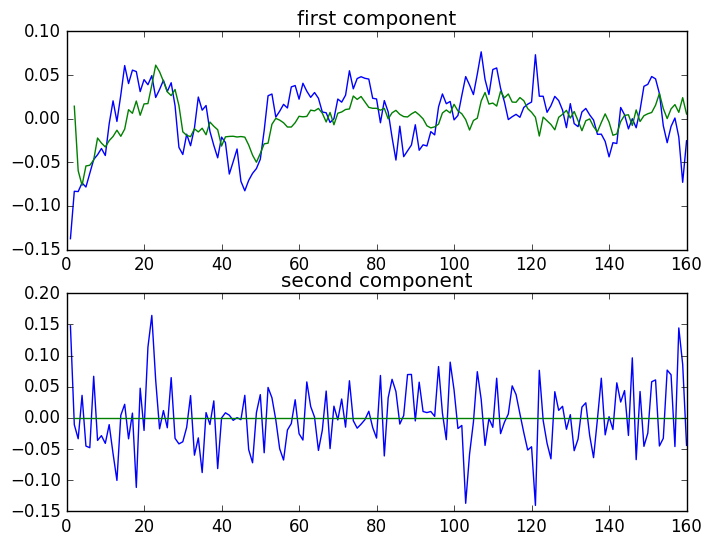

In [64]:
using PyPlot
subplot(211)
plot(1:160,data[1][:,1], label=L"$x_t$")
plot(2:161,[Xhat[t].μ[1] for t in 1:160], label=L"$\hat{x)_t$")
title("first component")
subplot(212)
plot(1:160,data[1][:,2], label=L"$x_t$")
plot(2:161,[Xhat[t].μ[2] for t in 1:160], label=L"$\hat{x)_t$")
title("second component");

Nothing can be inferred about the transitory component, since there is not autocorrelation between $x_t^1$ and $x_t^2$.

1.7
--

In [65]:
ρ_grid = collect(linspace(0,1,101));

Given the sample of $x_t$ drawn above the likelihood maximizing $\rho$ is:

In [66]:
ρ_grid[indmax([state_likelihood(
    LSSgeneralized([ρstar 0; 0 0 ], [σ1 0 0; 0 σ2 0], 
        [1 1], [0 0 σ3], [0, 0], [0.01 0; 0 0.01]),
    data[1])
        for ρstar in ρ_grid])]

0.81

Given the sample of $y_t$ drawn above the likelihood maximizing $\rho$ is:

In [67]:
ρ_grid[indmax([observation_likelihood(
    LSSgeneralized([ρstar 0; 0 0 ], [σ1 0 0; 0 σ2 0], 
        [1 1], [0 0 σ3], [0, 0], [0.01 0; 0 0.01]),
    data[2])
        for ρstar in ρ_grid])]

0.84

Quite good fit!